# Load data

In [25]:
import os
import pandas as pd

import pickle
from collections import Counter
from tqdm import tqdm
import numpy as np
import random

import seaborn as sns
from _00_text_utils import title_process, process_quoting, comment_process, selftext_process

In [2]:
df = pd.read_csv(f'{os.getcwd()}/data/data_active_authorExt.tsv', sep='\t')

## Determine which authors to fine-tune for baseline

In [58]:
author_cnt = Counter()
author_cnt.update(df.commAuthor.tolist())
author_cnt = sorted(author_cnt.items(), key=lambda x:x[1], reverse=True)

In [59]:
j, thr_list = 0, [2000, 1000, 500, 200, 100]
for i, elem in enumerate(author_cnt):
    if elem[1] <= thr_list[j]:
        print(f"{i} authors commented more than {thr_list[j]}")
        j += 1
    if j >= len(thr_list):
        break

6 authors commented more than 2000
8 authors commented more than 1000
9 authors commented more than 500
46 authors commented more than 200
219 authors commented more than 100


In [60]:
author_cnt[0], author_cnt[99], author_cnt[-1]

(('iluvcats17', 2863), ('Annual-Contract-115', 138), ('nebunala4328', 100))

# Create data splits for each redditor
- Create a train-test split
    - For the 8 authors in the previous set, we use the same test set
- For each author in train
    - Apply k-fold validation (k=5)
- Save all *author_train_k.npy*, *author_valid_k.npy*, and *author_test.npy*
- Check label distribution!

In [62]:
k = 5

In [89]:
AUTHORS = [elem[0] for elem in author_cnt[:224]]
TOP_AUTHORS = AUTHORS[:8]

In [81]:
df_active = pd.read_csv(f'{os.getcwd()}/data/data_active.tsv', sep='\t')

In [82]:
df_active_train = df_active.sample(frac=0.7, replace=False, random_state=2024)
df_active_test = df_active[~df_active.index.isin(df_active_train.index)]

In [84]:
test_IDs = []
for idx, row in df_active_test.iterrows():
    test_IDs.append(row['subID']+'###'+row['commAuthor'])

In [85]:
df['ID'] = df['subID']+'###'+df['commAuthor']

In [74]:
def df_to_npy(data, author, fold=0, split='test'):
    result_list = []
    for idx, row in data.iterrows():
        result_list.append({'subID':row['subID'], 'title':row['title'], 'selftext':row['selftext'], \
                            'comment':row['comment'], 'judgment':row['judgment']})
    if split == 'test':
        filepath = f"{os.getcwd()}/data/byRedditor/{author}_test.npy"
    elif split == 'testHard':
        filepath = f"{os.getcwd()}/data/byRedditor/{author}_testHard.npy"
    else:
        filepath = f"{os.getcwd()}/data/byRedditor/{author}_{split}_{fold}.npy"
        
    random.shuffle(result_list)
    np.save(filepath, result_list)
    return

### Create hardTest.npy

In [67]:
with open(f"{os.getcwd()}/data/subID_to_votes.pkl", "rb") as f:
    subID_to_votes = pickle.load(f)

In [71]:
controversial_ = []
for idx, row in df.iterrows():
    judgments = subID_to_votes[row['subID']]
    acceptable_portion = sum(judgments)/len(judgments)
    if acceptable_portion < 0.3 or acceptable_portion > 0.7:
        controversial_.append(0)
    else:
        controversial_.append(1)
df['controversial'] = controversial_

In [87]:
df.head()

,subID,title,selftext,commAuthor,comment,judgment,controversial,ID
0,h0lfjt,not wanting to share my wedding day with my br...,My (27F) fiancée (28M) and I have been dating ...,DocSternau,"Ah, allways with the wedding drama / competiti...",1,0,h0lfjt###DocSternau
1,h0ow13,I refuse to take responsibility for my daughte...,My(48) daughter(22) has had a laundry list of ...,Dachshundmom5,"your own post shows verbal abuse, manipulation...",0,0,h0ow13###Dachshundmom5
2,h0ow13,I refuse to take responsibility for my daughte...,My(48) daughter(22) has had a laundry list of ...,Lunavixen15,you don't deserve juice and a cookie for barel...,0,0,h0ow13###Lunavixen15
3,h0tjjz,not giving one of my friends special treatment?,"My friend, Katie (fake name) texted me today w...",teresajs,"She's clingy, demanding, and high maintenance....",1,0,h0tjjz###teresajs
4,h0eavk,"taking $15,000 out of my daughters college fun...","I have an 8 year old daughter, and to make col...",iluvcats17,You should never touch the fund for anything o...,0,0,h0eavk###iluvcats17


In [90]:
for _author in tqdm(AUTHORS):
    minidf = df[df['commAuthor']==_author]
    if _author in TOP_AUTHORS:
        minidf_test = minidf[minidf['ID'].isin(test_IDs)]
        minidf_trainvalid = minidf[~minidf.index.isin(minidf_test.index)]
    else:
        minidf_trainvalid = minidf.sample(frac=0.7, replace=False, random_state=2024)
        minidf_test = minidf[~minidf.index.isin(minidf_trainvalid.index)]

    df_to_npy(minidf_test, _author)

    minidf_test_hard = minidf_test[minidf_test['controversial']==1]
    df_to_npy(minidf_test_hard, _author, split="testHard")

    for i in range(k):
        minidf_train = minidf_trainvalid.sample(frac=0.858, replace=False, random_state=2024+i)
        minidf_valid = minidf_trainvalid[~minidf_trainvalid.index.isin(minidf_train.index)]
        df_to_npy(minidf_train, _author, i, "train")
        df_to_npy(minidf_valid, _author, i, "valid")

100%|████████████████████████████████████████████████████████████████████████| 224/224 [00:04<00:00, 48.53it/s]


### Check test set distribution

In [98]:
author_to_testHardIdx = {_author:[] for _author in AUTHORS}
for _author in tqdm(AUTHORS):
    minidf = df[df['commAuthor']==_author]
    if _author in TOP_AUTHORS:
        minidf_test = minidf[minidf['ID'].isin(test_IDs)]
        minidf_trainvalid = minidf[~minidf.index.isin(minidf_test.index)]
    else:
        minidf_trainvalid = minidf.sample(frac=0.7, replace=False, random_state=2024)
        minidf_test = minidf[~minidf.index.isin(minidf_trainvalid.index)]

    author_to_testHardIdx[_author] = minidf_test['controversial'].tolist()

    minidf_test_hard = minidf_test[minidf_test['controversial']==1]
    print(_author, len(minidf_test), len(minidf_test_hard))
with open(f"{os.getcwd()}/data/author_to_controversialIndex_byRedditor.pkl", "wb") as f:
    pickle.dump(author_to_testHardIdx, f)

 28%|████████████████████▎                                                   | 63/224 [00:00<00:00, 335.66it/s]

iluvcats17 841 134
ComprehensiveBand586 837 62
NoApollonia 770 158
holisarcasm 707 71
mm172 648 95
WebbieVanderquack 622 170
Knittingfairy09113 535 39
teresajs 543 51
No_Proposal7628 192 5
KnightofForestsWild 138 5
Ladyughsalot1 127 24
disruptionisbliss 126 6
OneTwoWee000 124 16
WinEquivalent4069 116 8
HexStarlight 114 4
Professional_Duck564 110 2
seba_make 107 9
DocSternau 106 8
voluntold9276 101 8
crystallz2000 95 5
Limerase 92 3
Kettlewise 90 2
cassowary32 90 6
JCBashBash 90 10
Viperbunny 89 8
DaniCapsFan 89 7
bibbiddybobbidyboo 83 4
brazentory 80 6
neutralgood079 77 3
Quicksilver1964 75 3
NeverRarelySometimes 73 10
fragilemagnoliax 72 2
Dachshundmom5 71 5
mfruitfly 71 5
Ok-Mode-2038 70 6
G8RTOAD 69 4
Algebralovr 67 6
slendermanismydad 67 5
Ohcrumbcakes 66 3
usernaym44 65 3
CMSkye 65 2
soph_lurk_2018 63 10
loudent2 63 13
BellaBlue06 62 8
meifahs_musungs 61 4
noccie 60 2
Scarletzoe 59 4
Cocoasneeze 59 7
EquivalentTwo1 59 4
Bangbangsmashsmash 58 15
The-Moocat 58 6
Medievalmoomin 56 6


 69%|████████████████████████████████████████████████▊                      | 154/224 [00:00<00:00, 414.30it/s]

Cent1234 46 3
mouse361 46 2
GrWr44 46 5
RevKyriel 46 0
Beautiful_mistakes 46 0
Kayliee73 45 7
Dogmother123 45 4
I_Suggest_Therapy 45 6
ConsistentCheesecake 44 2
Caitmk 43 3
Maiidesuu 42 3
naranghim 42 5
Renbarre 42 1
KiwiTurk2020 42 3
SigSauerPower320 42 1
Lunavixen15 42 2
gemma156 42 2
Diasies_inMyHair 42 4
Dana07620 41 3
Annual-Contract-115 41 5
DynkoFromTheNorth 41 0
idrow1 41 3
KarenMaca 41 5
Which_Pudding_4332 41 0
OftheSea95 41 6
bamf1701 41 4
mouse_attack 40 2
KathAlMyPal 40 4
ScarletDarkstar 40 4
adotfree 40 3
NotYourMommyDear 40 2
kaitou1011 40 10
Korrin 40 6
tmchd 40 2
SuperLoris 40 6
StrykerC13 39 4
FPFan 39 0
GaGypsyGirl 39 1
TeamChaos17 39 1
ScarletteMayWest 39 4
Katy_moxie 39 1
DubiousPeoplePleaser 39 4
Careless-Image-885 39 4
markdmac 38 5
8kijcj 38 0
MischievousBish 38 0
hecknono 38 2
yellowchaitea 38 0
MadTrophyWife 38 2
carissadraws 37 4
sportsphotographer84 37 2
neeksknowsbest 37 2
lyan-cat 37 3
Forteanforever 37 2
EconomyVoice7358 37 2
Marzipan_civil 37 1
annshine 3

100%|███████████████████████████████████████████████████████████████████████| 224/224 [00:00<00:00, 398.93it/s]

kikivee612 33 2
DiligentPenguin16 33 2
pugapooh 33 0
The__Riker__Maneuver 33 1
Ariyanwrynn1989 33 8
Top_Detective9184 33 1
Notsogoodadvicegiver 33 4
ZenDendou 33 4
sassyandsweer789 33 9
SurrealGirl 33 0
DeepTie6252 33 1
XxhumanguineapigxX 32 8
FirebirdWriter 32 2
LiveLovelyLala 32 2
thejexorcist 32 4
chanteusetriste 32 1
MonkeyWrench 32 5
Piercedbunny 32 1
TheDevilsAdvokaat 32 2
Throwawayhater3343 32 2
fatfarko69 32 0
KT_mama 32 2
gemw2101 32 1
randomusername71175 32 4
oldcreaker 32 1
DameofDames 32 1
starwarschick16 31 3
ronearc 31 4
Ancient-Transition-4 31 2
Deucalion666 31 0
Repulsive-Nerve5127 31 1
Glasgowghirl67 31 1
iesharael 31 4
SnooGiraffes3591 31 2
littlehappyfeets 31 1
nerdyconstructiongal 31 3
Froggetpwagain 31 0
Mirianda666 31 6
MPBoomBoom22 31 4
iBeFloe 31 5
beez8383 30 2
carolinemathildes 30 6
emotionally_autistic 30 6
Magus_Corgo 30 4
MaryAnne0601 30 1
PsychologicalPhone94 30 1
patjames904 30 2
FloatingPencil 30 3
BugsRatty 30 4
jcaashby 30 3
AggravatingPatient18 30 5
s

In [101]:
with open(f"{os.getcwd()}/outputs/distilbert-base-uncased_author_results_hard.pkl", "rb") as f:
    author_results = pickle.load(f)

### Check label distribution

In [78]:
for _author in AUTHORS:
    minidf = df[df['commAuthor']==_author]
    minidf_trainvalid = minidf.sample(frac=0.7, replace=False, random_state=2024)
    minidf_test = minidf[~minidf.index.isin(minidf_trainvalid.index)]
    
    test_judgments = minidf_test['judgment'].tolist()
    test_distribution = sum(test_judgments)/len(test_judgments)
    print(_author)
    print(f"test dist: {int(test_distribution*10000)/100}")
    # df_to_npy(minidf_test, _author)

    for i in range(k):
        minidf_train = minidf_trainvalid.sample(frac=0.858, replace=False, random_state=2024+i)
        minidf_valid = minidf_trainvalid[~minidf_trainvalid.index.isin(minidf_train.index)]

        train_judgments = minidf_train['judgment'].tolist()
        train_distribution = sum(train_judgments)/len(train_judgments)

        valid_judgments = minidf_valid['judgment'].tolist()
        valid_distribution = sum(valid_judgments)/len(valid_judgments)
        print(f"({i}) train: {int(train_distribution*10000)/100} / valid: {int(valid_distribution*10000)/100}")
    print()
        # df_to_npy(minidf_train, _author, i, "train")
        # df_to_npy(minidf_valid, _author, i, "valid")

iluvcats17
test dist: 77.53
(0) train: 77.83 / valid: 73.68
(1) train: 77.31 / valid: 76.84
(2) train: 77.66 / valid: 74.73
(3) train: 77.31 / valid: 76.84
(4) train: 77.77 / valid: 74.03

ComprehensiveBand586
test dist: 53.19
(0) train: 52.7 / valid: 53.7
(1) train: 52.7 / valid: 53.7
(2) train: 52.57 / valid: 54.44
(3) train: 52.7 / valid: 53.7
(4) train: 53.31 / valid: 50.0

NoApollonia
test dist: 44.77
(0) train: 48.21 / valid: 50.38
(1) train: 48.59 / valid: 48.07
(2) train: 48.59 / valid: 48.07
(3) train: 48.85 / valid: 46.53
(4) train: 47.89 / valid: 52.3

holisarcasm
test dist: 74.48
(0) train: 73.76 / valid: 72.91
(1) train: 74.1 / valid: 70.83
(2) train: 73.62 / valid: 73.75
(3) train: 73.76 / valid: 72.91
(4) train: 74.1 / valid: 70.83

mm172
test dist: 56.2
(0) train: 59.35 / valid: 63.43
(1) train: 59.94 / valid: 59.91
(2) train: 60.01 / valid: 59.47
(3) train: 60.01 / valid: 59.47
(4) train: 59.72 / valid: 61.23

WebbieVanderquack
test dist: 47.03
(0) train: 46.55 / valid

### visualize author's judgment distributions

In [29]:
minidf = df[df['commAuthor'].isin(AUTHORS)]
author_to_judgments = {_author:[] for _author in AUTHORS}
for idx, row in minidf.iterrows():
    author_to_judgments[row['commAuthor']].append(row['judgment'])

author_to_judgment_dist = {_author:sum(author_to_judgments[_author])/len(author_to_judgments[_author]) for _author in AUTHORS}

In [30]:
author_to_judgment_dist_tup = author_to_judgment_dist.items()
df_viz = pd.DataFrame(data={'authors':[elem[0] for elem in author_to_judgment_dist_tup], 'dists':[elem[1] for elem in author_to_judgment_dist_tup]})

<Axes: xlabel='dists', ylabel='Count'>

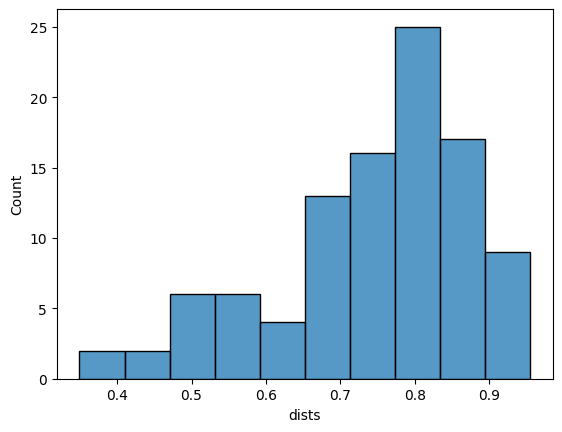

In [31]:
sns.histplot(data=df_viz, x="dists")

In [32]:
author_to_judgment_dist_s = sorted(author_to_judgment_dist.items(), key=lambda x:x[1])